# FashionMNIST VAE

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import torch
import torchvision
import torchvision.transforms as tvt
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO #, TraceGraph_ELBO
from pyro.optim import Adam, Adamax, Adadelta, SGD
from torchvision import utils
from matplotlib.pyplot import imshow
from torch.distributions import constraints
from sklearn.manifold import TSNE

from helper_functions import *
from encoder_decoder_vae import *

### Define the simulation parameters

In [2]:
params = { 
    'K' : 10, #number of clusters
    'SCALE' : 0.1,
    'CHANNELS' : 1,
    'WIDTH' : 28,
    'HEIGHT':28,
    'Z_DIM':20,
    'use_cuda' : torch.cuda.is_available()
    }
print(params)

{'K': 10, 'SCALE': 0.1, 'CHANNELS': 1, 'WIDTH': 28, 'HEIGHT': 28, 'Z_DIM': 20, 'use_cuda': False}


### Get the data

torch.Size([64, 1, 28, 28])


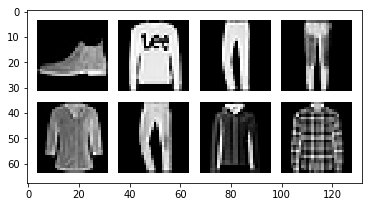

In [3]:
BATCH_SIZE = 64
kwargs = {'num_workers': 0, 'pin_memory': params["use_cuda"]}

trainset = torchvision.datasets.FashionMNIST('./FashionMNIST', train=True, download=True, transform=tvt.ToTensor())
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, **kwargs)
testset = torchvision.datasets.FashionMNIST('./FashionMNIST', train=False, download=True, transform=tvt.ToTensor())
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, **kwargs)

imgs,labels = next(iter(testloader))

print(imgs.shape)
show_batch(imgs[:8],npadding=4)

### Define the VAE class 
This is the case without latent structure

In [8]:
import pyro
class VAE_with_latent_structure(torch.nn.Module):
    
    def __init__(self,params,encoder,decoder):
        super().__init__()
        
        # Parameters
        self.use_cuda = params['use_cuda']
        self.scale  = params['SCALE']
        self.K      = params['K']
        self.ch     = params['CHANNELS']
        self.width  = params['WIDTH']
        self.height = params['HEIGHT']
        self.z_dim  = params['Z_DIM']
        self.x_dim = self.ch*self.width*self.height
        
        # Instantiate the encoder and decoder
        self.decoder = decoder
        self.encoder = encoder
        
        if(self.use_cuda):
            self.cuda()
        
    def guide(self, imgs=None):
        """ 1. run the inference to get: zwhere,zwhat
            2. sample latent variables 
        """       
        #-----------------------#
        #--------  Trick -------#
        #-----------------------#
        if(imgs is None):
            observed = False
            imgs = torch.zeros(8,self.ch,self.height,self.width)
            if(self.use_cuda):
                imgs=imgs.cuda()
        else:
            observed = True
        #-----------------------#
        #----- Enf of Trick ----#
        #-----------------------#

        batch_size,ch,width,height = imgs.shape
        pyro.module("encoder", self.encoder)

        # Global variables
        locs_mu = pyro.param("locs_mu",0.2*torch.randn((self.K,self.z_dim),device=imgs.device))
        locs_q = pyro.sample('locs', dist.Delta(locs_mu).to_event(2))
        
        with pyro.plate('batch_size', batch_size, dim=-1):
            p,dz_mu,dz_std = self.encoder(imgs)
            assignment = pyro.sample('assignment',dist.Categorical(p))
            z_mu = locs_q[assignment] + dz_mu*self.scale
            pyro.sample('z_latent', dist.Normal(z_mu,dz_std).to_event(1))
        return p,z_mu,dz_std
            
    def model(self, imgs=None):
        """ 1. sample the latent from the prior:
            2. runs the generative model
            3. score the generative model against actual data 
        """
        #-----------------------#
        #--------  Trick -------#
        #-----------------------#
        if(imgs is None):
            observed = False
            imgs = torch.zeros(8,self.ch,self.height,self.width)
            if(self.use_cuda):
                imgs=imgs.cuda()
        else:
            observed = True
        #-----------------------#
        #----- Enf of Trick ----#
        #-----------------------#
            
        batch_size,ch,width,height = imgs.shape
        pyro.module("decoder", self.decoder)
        sigma = pyro.param("sigma", 0.01*imgs.new_ones(1))
        
        # Global variable
        locs = pyro.sample('locs', dist.Normal(0., 10.*imgs.new_ones(self.K,self.z_dim)).to_event(2))

        # Variable for each image
        with pyro.plate('batch_size', batch_size, dim=-1):
            assignment = pyro.sample('assignment', dist.Categorical(imgs.new_ones(self.K)))
            z = pyro.sample('z_latent', dist.Normal(locs[assignment], self.scale).to_event(1))
            x_mu = self.decoder(z) #x_mu is between 0 and 1
            pyro.sample('obs', dist.Normal(x_mu.view(batch_size,-1),sigma).to_event(1), obs=imgs.view(batch_size,-1))    

    def reconstruct(self,imgs):
        p,dz_mu,dz_std = self.encoder(imgs)
        assignment = torch.argmax(p, dim=1)
        print(assignment.shape)
        locs = pyro.param('locs_mu')
        z_mu = locs[assignment] + dz_mu*self.scale
        x = self.decoder(z_mu)
        return x

torch.Size([64])


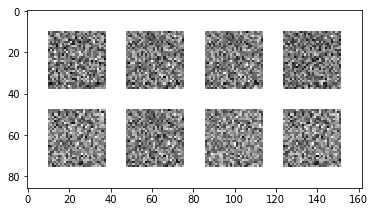

In [9]:
encoder = MLP_x_to_p_dz(params)
decoder = MLP_z_to_x(params)
vae = VAE_with_latent_structure(params,encoder,decoder)
vae.guide()
vae.model()
imgs_rec = vae.reconstruct(imgs)
show_batch(imgs_rec[:8])

In [10]:
test_model(vae.model,vae.guide,Trace_ELBO())

#load_model(vae,"/Users/ldalessi/ENUMERATION_MNIST/ARCHIVE/","vae_v5_10")

import pyro.poutine as poutine
#
print("----MODEL---------")
trace = poutine.trace(vae.model).get_trace()
trace.compute_log_prob()  # optional, but allows printing of log_prob shapes
print(trace.format_shapes())
#
print("----GUIDE ---------")
trace = poutine.trace(vae.guide).get_trace()
trace.compute_log_prob()  # optional, but allows printing of log_prob shapes
print(trace.format_shapes())

----MODEL---------
             Trace Shapes:               
              Param Sites:               
decoder$$$comp_x_mu.weight 784  20       
  decoder$$$comp_x_mu.bias     784       
                     sigma       1       
             Sample Sites:               
                 locs dist       |  10 20
                     value       |  10 20
                  log_prob       |       
           batch_size dist       |       
                     value   8   |       
                  log_prob       |       
           assignment dist   8   |       
                     value   8   |       
                  log_prob   8   |       
             z_latent dist   8   |  20   
                     value   8   |  20   
                  log_prob   8   |       
                  obs dist   8   | 784   
                     value   8   | 784   
                  log_prob   8   |       
----GUIDE ---------
               Trace Shapes:             
                Param Sites:         

In [11]:
pyro.clear_param_store()
pyro.set_rng_seed(0)

TEST_FREQUENCY = 5
WRITE_FREQUENCY = 20
smoke_test= False
if(smoke_test):
    pyro.enable_validation(True)
    pyro.distributions.enable_validation(True)
    NUM_EPOCHS = 21
else:
    pyro.enable_validation(False)
    pyro.distributions.enable_validation(False)
    NUM_EPOCHS = 101
    
# setup the optimizer
adam_args = {"lr": 1.0e-4}
#optimizer = Adadelta(adam_args)
optimizer = Adamax(adam_args)
svi = SVI(vae.model, vae.guide, optimizer, loss=Trace_ELBO(num_particles=1))
loss_train_history = list()
loss_test_history = list()
min_loss = 999999

In [29]:
write_dir  = '/Users/ldalessi/clustering/ARCHIVE/'
name_vae  = "vae_with_structure_v1_"
name_train_loss = "loss_train_with_structure_v1_"
name_test_loss = "loss_test_with_structure_v1_"
save_obj(params,write_dir,"params_with_structure_v1_")


# training loop
for epoch in range(102,2*NUM_EPOCHS):
    vae.train()    
    loss = train(svi,trainloader,use_cuda=params['use_cuda'])
    loss_train_history.append(loss)
    print("[epoch %03d] train loss: %.4f" % (epoch, loss))
       
    if(epoch < 4 % 20): 
        save_model(vae,write_dir,name_vae+str(epoch))       
        save_obj(loss_train_history,write_dir,name_train_loss+str(epoch))
        save_obj(loss_test_history,write_dir,name_test_loss+str(epoch))
    
    if(epoch % TEST_FREQUENCY ==0):
        vae.eval()
        loss_test = evaluate(svi,testloader,use_cuda=params['use_cuda'])
        loss_test_history.append(loss_test)
        if(loss_test < min_loss):
            min_loss = loss_test
            save_model(vae,write_dir,name_vae+str(epoch))       
            save_obj(loss_train_history,write_dir,name_train_loss+str(epoch))
            save_obj(loss_test_history,write_dir,name_test_loss+str(epoch))
            print("[epoch %03d]  test loss: %.4f --New Record--" % (epoch, loss_test)) 
        else:
            print("[epoch %03d]  test loss: %.4f" % (epoch, loss_test)) 

[epoch 102] train loss: -52.5156
[epoch 103] train loss: -53.9923
[epoch 104] train loss: -54.7288
[epoch 105] train loss: -56.8289
[epoch 105]  test loss: -58.2836 --New Record--
[epoch 106] train loss: -58.0253
[epoch 107] train loss: -59.3455
[epoch 108] train loss: -60.7513
[epoch 109] train loss: -62.5577
[epoch 110] train loss: -65.4497
[epoch 110]  test loss: -66.7588 --New Record--
[epoch 111] train loss: -66.6427
[epoch 112] train loss: -68.6915
[epoch 113] train loss: -70.0561
[epoch 114] train loss: -72.4698
[epoch 115] train loss: -73.3826
[epoch 115]  test loss: -75.0718 --New Record--
[epoch 116] train loss: -74.4585
[epoch 117] train loss: -76.2334
[epoch 118] train loss: -77.8246
[epoch 119] train loss: -79.4334
[epoch 120] train loss: -81.3319
[epoch 120]  test loss: -81.7093 --New Record--
[epoch 121] train loss: -82.3757
[epoch 122] train loss: -83.8284
[epoch 123] train loss: -85.4190
[epoch 124] train loss: -86.4950
[epoch 125] train loss: -88.5832
[epoch 125]  tes

KeyboardInterrupt: 

# Check the results

In [30]:
write_dir  = '/Users/ldalessi/clustering/ARCHIVE/'
load_model(vae,write_dir,"vae_with_structure_v1_130")
loss_train_history=load_obj(write_dir,"loss_train_with_structure_v1_130")
loss_test_history=load_obj(write_dir,"loss_test_with_structure_v1_130")

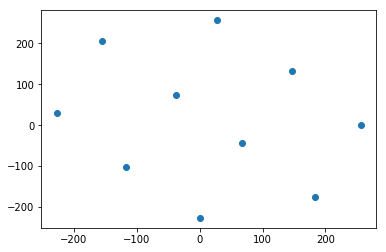

In [31]:
x_mu = pyro.param('locs_mu')
x_mu = x_mu.detach().cpu().numpy()
#print(type(x))
#plt.scatter(x_mu[:,0],x_mu[:,1])

x_mu_tsne = TSNE(n_components=2).fit_transform(x_mu)


plt.scatter(x_mu_tsne[:,0],x_mu_tsne[:,1])

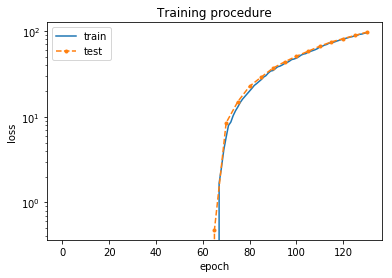

In [32]:
plt.plot(np.arange(0, len(loss_train_history)), -1*np.array(loss_train_history))
plt.plot(np.arange(0, len(loss_train_history), TEST_FREQUENCY), -1*np.array(loss_test_history), '.--')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.yscale('log')
plt.title('Training procedure')
plt.legend(['train', 'test'])
plt.show()

In [40]:
# compute the embedding                                   

for i,data in enumerate(testloader):
    imgs,labs = data
    if(params['use_cuda']):
        imgs=imgs.cuda()
    p,dz_mu,dz_std = vae.encoder(imgs)
    k = torch.argmax(p, dim=1)
    locs = pyro.param('locs_mu')
    z_mu_tmp = locs[k] + dz_mu*vae.scale
    
    if(i==0):
        x_np = imgs.view(imgs.shape[0],-1).detach().cpu().numpy()
        z_np = z_mu_tmp.detach().cpu().numpy()
        labels = labs.numpy()
        assignment = k.numpy()
        
    else:
        x_np = np.concatenate((x_np,imgs.view(imgs.shape[0],-1).detach().cpu().numpy()),axis=0)
        z_np = np.concatenate((z_np,z_mu_tmp.detach().cpu().numpy()),axis=0)
        labels = np.concatenate((labels, labs.numpy()),axis=0)
        assignment = np.concatenate((assignment, k.numpy()),axis=0)
    
    if z_np.shape[0] >= 3000:
        break

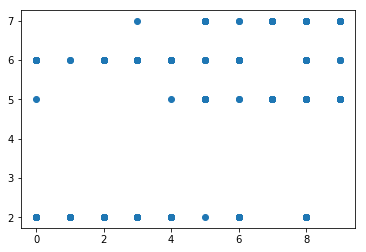

In [41]:
plt.scatter(labels,assignment)

In [20]:
x_tsne = TSNE(n_components=2).fit_transform(x_np)

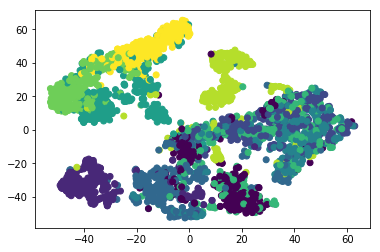

In [21]:
plt.scatter(x_tsne[:,0],x_tsne[:,1],c=labels)    
#plt.xlim(-1.0,1.0)
#plt.ylim(-1.0,1.0)

In [35]:
z_tsne = TSNE(n_components=2).fit_transform(z_np)

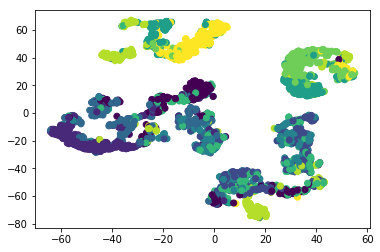

In [42]:
plt.scatter(z_tsne[:,0],z_tsne[:,1],c=labels)

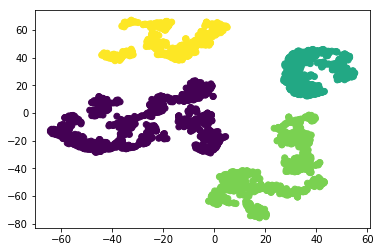

In [43]:
plt.scatter(z_tsne[:,0],z_tsne[:,1],c=assignment)

torch.Size([64])


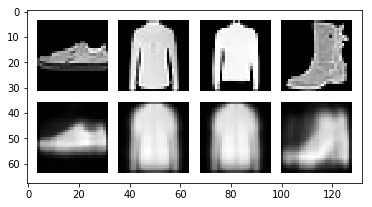

In [37]:
#imgs,labels = next(iter(testloader))
imgs,labels = next(iter(trainloader))
imgs_rec = vae.reconstruct(imgs)
show_2_batch(imgs[:4],imgs_rec[:4],npadding=4)